# Bill Cobb's Vehicle Dynamics Professionals' July 2024 Challenge - #5

Given the results of various step steer responses at increasing steering
magnitudes, compute the understeer gradient, cornering compliance with respect
to lateral acceleration, and the step steer response metrics with respect to
lateral acceleration. The vehicle is a generic car with non-linear steering and
non-linear tires simulated with Bill Cobb's BZ3 simulation program.

The original challenge text from reads as follows:

> OK, I promise: Last exam question.  60 lines in Matlab.  Where are the snake charmers and musicians ?


In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import control as ct

In [3]:
plt.style.use("seaborn-v0_8")

## Part 1: Define Constants

We are given known quantities of the vehicle under test. Define them as constants.


In [4]:
VEHICLE_WB = 2.745  # m
VEHICLE_SR = 20.0  # rad/rad
VEHICLE_WF = 1000  # kg
VEHICLE_WR = 600  # kg
VEHICLE_M = VEHICLE_WF + VEHICLE_WR
VEHICLE_LA = VEHICLE_WB * (VEHICLE_WR / VEHICLE_M)
VEHICLE_LB = VEHICLE_WB * (VEHICLE_WF / VEHICLE_M)

Use constants for column header names to make it easier to access.


In [5]:
# Provided columns
COLUMN_TIME = "TIME, sec"
COLUMN_LATACC = "LATACC, g"
COLUMN_RUN = "RUN, RUN"
COLUMN_BETA = "SIDSLP, deg"
COLUMN_SPEED = "SPEED, kph"
COLUMN_STEER = "STEER, deg"
COLUMN_YAWVEL = "YAWVEL, deg/sec"

# Computed columns
COLUMN_LATACC_SI = "LATACC, m/s^2"
COLUMN_BETA_SI = "BETA, rad"
COLUMN_SPEED_SI = "SPEED, m/s"
COLUMN_STEER_SI = "STEER, rad"
COLUMN_DELTA = "DELTA, deg"
COLUMN_DELTA_SI = "DELTA, rad"
COLUMN_YAWVEL_SI = 'YAWVEL, rad/s'

# Math channels
COLUMN_DF = "DF, rad/G"
COLUMN_DR = "DR, rad/G"
COLUMN_USG = "USG, rad/G"

# Step channels
COLUMN_RT = "RiseTime"
COLUMN_ST = "SettlingTime"
COLUMN_SMIN = "SettlingMin"
COLUMN_SMAX = "SettlingMax"
COLUMN_OS = "Overshoot"
COLUMN_US = "Undershoot"
COLUMN_P = "Peak"
COLUMN_PT = "PeakTime"
COLUMN_SS = "SteadyStateValue"

Define common conversion factors.


In [6]:
STD_G = 9.81
DEG2RAD = np.pi / 180.0
RAD2DEG = 1 / DEG2RAD
KPH2MPS = 1000 / 3600.0
MPS2KPH = 1 / KPH2MPS
M2FT = 3.28084

## Part 2: Data Wrangling


### Load in the data


Read in the data and sanitize it for consumption. The data has the following form:

| Row number | Description                                                                       | Sample                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| ---------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Line 1     | Comment header describing the contents of the CSV and relevant vehicle parameters | `"BZ3 Nonlinear Vehicle Dynamics Simulation WB=2745mm SR= 20  WF= 1000 kg WR= 600 kg "` |
| Line 2     | Column header names and units                                                     | `"TIME, sec";"LATACC, g";"RUN, RUN";"SIDSLP, deg";"SPEED, kph";"STEER, deg";"YAWVEL, deg/sec";                                                                                                                                                                                                                                                                                                                                       ;` |
| Line 3+    | Time series data                                                                  | `0.210    ;-0.000   ;1.000    ;0.000    ;100.000  ;0.000    ;-0.000    ` |


In [7]:
FILE_PATH = "../data/marc5.csv"

In [8]:
df = pl.read_csv(FILE_PATH, skip_rows=1, columns=range(7), separator=";").with_columns(
    pl.col("*").str.extract(r"(^-?\d+[.\d]*)").str.to_decimal()
)
df

"TIME, sec","LATACC, g","RUN, RUN","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]"
0.000,0.000,1.000,0.000,100.000,0.000,0.000
0.010,0.000,1.000,0.000,100.000,0.000,0.000
0.020,0.000,1.000,0.000,100.000,0.000,0.000
0.030,0.000,1.000,0.000,100.000,0.000,0.000
0.040,0.000,1.000,0.000,100.000,0.000,0.000
…,…,…,…,…,…,…
3.960,0.880,15.000,-2.203,100.000,75.000,17.800
3.970,0.880,15.000,-2.203,100.000,75.000,17.800
3.980,0.880,15.000,-2.203,100.000,75.000,17.800


### Convert to SI units

Perform all calculations in SI units.


In [9]:
df = df.with_columns(
    (pl.col(COLUMN_LATACC).cast(pl.Float32) * STD_G).alias(COLUMN_LATACC_SI),
    (pl.col(COLUMN_BETA).cast(pl.Float32) * DEG2RAD).alias(COLUMN_BETA_SI),
    (pl.col(COLUMN_SPEED).cast(pl.Float32) * KPH2MPS).alias(COLUMN_SPEED_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD).alias(COLUMN_STEER_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) / VEHICLE_SR).alias(COLUMN_DELTA),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD / VEHICLE_SR).alias(
        COLUMN_DELTA_SI
    ),
    (pl.col(COLUMN_YAWVEL).cast(pl.Float32) * DEG2RAD).alias(COLUMN_YAWVEL_SI),
)
df

"TIME, sec","LATACC, g","RUN, RUN","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","YAWVEL, rad/s"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32
0.000,0.000,1.000,0.000,100.000,0.000,0.000,0.0,0.0,27.777779,0.0,0.0,0.0,0.0
0.010,0.000,1.000,0.000,100.000,0.000,0.000,0.0,0.0,27.777779,0.0,0.0,0.0,0.0
0.020,0.000,1.000,0.000,100.000,0.000,0.000,0.0,0.0,27.777779,0.0,0.0,0.0,0.0
0.030,0.000,1.000,0.000,100.000,0.000,0.000,0.0,0.0,27.777779,0.0,0.0,0.0,0.0
0.040,0.000,1.000,0.000,100.000,0.000,0.000,0.0,0.0,27.777779,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
3.960,0.880,15.000,-2.203,100.000,75.000,17.800,8.6328,-0.03845,27.777779,1.308997,3.75,0.06545,0.310669
3.970,0.880,15.000,-2.203,100.000,75.000,17.800,8.6328,-0.03845,27.777779,1.308997,3.75,0.06545,0.310669
3.980,0.880,15.000,-2.203,100.000,75.000,17.800,8.6328,-0.03845,27.777779,1.308997,3.75,0.06545,0.310669


### Visualize provided data

Plot the timeseries to see what we are working with.


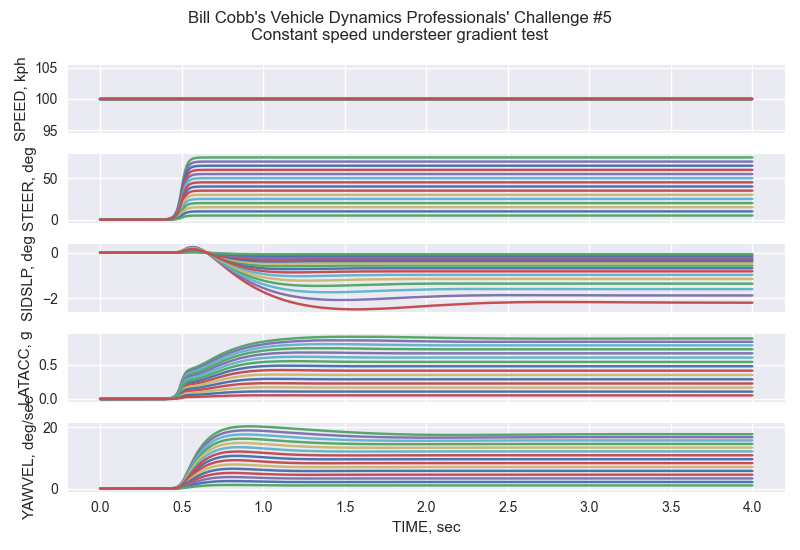

In [10]:
fig, axes = plt.subplots(5, 1, sharex=True)

# Plot
columns = [COLUMN_SPEED, COLUMN_STEER, COLUMN_BETA, COLUMN_LATACC, COLUMN_YAWVEL]
for ax, col in zip(axes, columns):
    for name, data in df.group_by(COLUMN_RUN):
        ax.plot(data[COLUMN_TIME], data[col], label=f"Run {name}")
    ax.set_ylabel(col)

# Labels
axes[-1].set_xlabel(COLUMN_TIME)

# Title
fig.suptitle(
    "Bill Cobb's Vehicle Dynamics Professionals' Challenge #5\nConstant speed understeer gradient test"
)

plt.tight_layout()
plt.show()

## Part 3: Data Exploration


As a constant speed understeer gradient test, what is the test speed?


In [11]:
vehicle_speed = df[COLUMN_SPEED_SI].median()
print(f"Vehicle speed: {vehicle_speed:.2f} m/s")
print(f"Vehicle speed: {vehicle_speed * MPS2KPH:.2f} km/h")

Vehicle speed: 27.78 m/s
Vehicle speed: 100.00 km/h


### Extract the steady-state response from each run


In [12]:
# Steady-state dataframe (sdf)
sdf = df.group_by(COLUMN_RUN).tail(1).sort(by=COLUMN_LATACC)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","YAWVEL, rad/s"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32
1.000,4.000,0.052,-0.062,100.000,5.000,1.047,0.51012,-0.001082,27.777779,0.087266,0.25,0.004363,0.018274
2.000,4.000,0.107,-0.130,100.000,10.000,2.165,1.04967,-0.002269,27.777779,0.174533,0.5,0.008727,0.037786
3.000,4.000,0.165,-0.203,100.000,15.000,3.337,1.61865,-0.003543,27.777779,0.261799,0.75,0.01309,0.058242
4.000,4.000,0.225,-0.282,100.000,20.000,4.550,2.20725,-0.004922,27.777779,0.349066,1.0,0.017453,0.079412
5.000,4.000,0.286,-0.367,100.000,25.000,5.793,2.80566,-0.006405,27.777779,0.436332,1.25,0.021817,0.101107
…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.000,4.000,0.664,-1.156,100.000,55.000,13.423,6.51384,-0.020176,27.777779,0.959931,2.75,0.047997,0.234276
12.000,4.000,0.723,-1.364,100.000,60.000,14.627,7.09263,-0.023806,27.777779,1.047198,3.0,0.05236,0.255289
13.000,4.000,0.780,-1.606,100.000,65.000,15.772,7.6518,-0.02803,27.777779,1.134464,3.25,0.056723,0.275273


## Part 4: Extract metrics

From a constant speed understeer gradient test, we can compute the understeer
gradient from the measured steering response and the rear cornering compliance
from the measured sideslip response by subtracting the geometric terms from the
gradients.


### Helper functions

Place boilerplate reusable code before we begin our computation.


In [13]:
def gradient(x, y, s=0.0):
    """Compute gradients by fitting a smoothing spline to the data."""
    f = sp.interpolate.splrep(x, y, s=s)
    return sp.interpolate.splev(x, f, der=1)


def interpolate(x, y, xeval):
    """Interpolate x and y at xeval"""
    f = sp.interpolate.CubicSpline(x, y)
    return f(xeval)

### Understeer gradient

The understeer gradient is a gain on lateral acceleration that modifies the required road wheel angle to meet a specified corner radius. Recall:

$$ \delta = \frac{L}{R} + Ka_y $$

The corner radius can be calculated from the vehicle lateral acceleration.

$$ a_y = \frac{u^2}{R} $$

Substituting, the understeer gradient equation becomes the following.

$$ \delta = \left(\frac{L}{u^2} + K \right) a_y $$

Implicitly differentiating and solving for the understeer gradient.

$$ K = \frac{d\delta}{da_y} - \frac{L}{u^2} $$


In [14]:
# With units of rad/G
smooth_factor = 0.001
sdf = sdf.with_columns(
    pl.Series(
        name=COLUMN_USG,
        values=STD_G
        * (
            gradient(sdf[COLUMN_LATACC_SI], sdf[COLUMN_DELTA_SI], s=smooth_factor)
            - (VEHICLE_WB / sdf[COLUMN_SPEED_SI] ** 2)
        ),
    )
)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","YAWVEL, rad/s","USG, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64
1.000,4.000,0.052,-0.062,100.000,5.000,1.047,0.51012,-0.001082,27.777779,0.087266,0.25,0.004363,0.018274,0.047065
2.000,4.000,0.107,-0.130,100.000,10.000,2.165,1.04967,-0.002269,27.777779,0.174533,0.5,0.008727,0.037786,0.043238
3.000,4.000,0.165,-0.203,100.000,15.000,3.337,1.61865,-0.003543,27.777779,0.261799,0.75,0.01309,0.058242,0.039854
4.000,4.000,0.225,-0.282,100.000,20.000,4.550,2.20725,-0.004922,27.777779,0.349066,1.0,0.017453,0.079412,0.037059
5.000,4.000,0.286,-0.367,100.000,25.000,5.793,2.80566,-0.006405,27.777779,0.436332,1.25,0.021817,0.101107,0.034952
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.000,4.000,0.664,-1.156,100.000,55.000,13.423,6.51384,-0.020176,27.777779,0.959931,2.75,0.047997,0.234276,0.038418
12.000,4.000,0.723,-1.364,100.000,60.000,14.627,7.09263,-0.023806,27.777779,1.047198,3.0,0.05236,0.255289,0.041526
13.000,4.000,0.780,-1.606,100.000,65.000,15.772,7.6518,-0.02803,27.777779,1.134464,3.25,0.056723,0.275273,0.045187


### Rear cornering compliance

From first principles, cornering compliance is the steady-state change in slip
angle with respect to lateral acceleration.

$$ D = -\frac{d\alpha}{da_y}$$

The slip angle of the rear axle in steady-state is the summation of the side
slip angle $\beta$ and the geometric component induced by the yaw velocity.
Assuming in SAE J670 coordinates.

$$ \alpha_r = \beta - \frac{l_b a_y}{u^2} $$

Implicitly differentiating knowing that vehicle speed is constant.

$$ d\alpha_r = d\beta - \frac{l_b da_y}{u^2} $$
$$ \frac{d\alpha_r}{da_y} = \frac{d\beta}{da_y} - \frac{l_b}{u^2} $$

The rear cornering compliance the derived to be as follows.

$$ D_r = \frac{l_b}{u^2} - \frac{d\beta}{da_y} $$


In [15]:
# With units of rad/G
smooth_factor = 0.001
sdf = sdf.with_columns(
    pl.Series(
        name=COLUMN_DR,
        values=STD_G
        * (
            (VEHICLE_LB / sdf[COLUMN_SPEED_SI] ** 2)
            - gradient(sdf[COLUMN_LATACC_SI], sdf[COLUMN_BETA_SI], s=smooth_factor)
        ),
    )
)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","YAWVEL, rad/s","USG, rad/G","DR, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64,f64
1.000,4.000,0.052,-0.062,100.000,5.000,1.047,0.51012,-0.001082,27.777779,0.087266,0.25,0.004363,0.018274,0.047065,0.052029
2.000,4.000,0.107,-0.130,100.000,10.000,2.165,1.04967,-0.002269,27.777779,0.174533,0.5,0.008727,0.037786,0.043238,0.048241
3.000,4.000,0.165,-0.203,100.000,15.000,3.337,1.61865,-0.003543,27.777779,0.261799,0.75,0.01309,0.058242,0.039854,0.045622
4.000,4.000,0.225,-0.282,100.000,20.000,4.550,2.20725,-0.004922,27.777779,0.349066,1.0,0.017453,0.079412,0.037059,0.044398
5.000,4.000,0.286,-0.367,100.000,25.000,5.793,2.80566,-0.006405,27.777779,0.436332,1.25,0.021817,0.101107,0.034952,0.044704
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.000,4.000,0.664,-1.156,100.000,55.000,13.423,6.51384,-0.020176,27.777779,0.959931,2.75,0.047997,0.234276,0.038418,0.08143
12.000,4.000,0.723,-1.364,100.000,60.000,14.627,7.09263,-0.023806,27.777779,1.047198,3.0,0.05236,0.255289,0.041526,0.092574
13.000,4.000,0.780,-1.606,100.000,65.000,15.772,7.6518,-0.02803,27.777779,1.134464,3.25,0.056723,0.275273,0.045187,0.104729


### Front cornering compliance

Recall that the understeer gradient is the difference between front and rear cornering compliances.

$$ K = D_f - D_r $$

Therefore.

$$ D_f = D_r + K $$


In [16]:
sdf = sdf.with_columns((pl.col(COLUMN_DR) + pl.col(COLUMN_USG)).alias(COLUMN_DF))
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","YAWVEL, rad/s","USG, rad/G","DR, rad/G","DF, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64,f64,f64
1.000,4.000,0.052,-0.062,100.000,5.000,1.047,0.51012,-0.001082,27.777779,0.087266,0.25,0.004363,0.018274,0.047065,0.052029,0.099095
2.000,4.000,0.107,-0.130,100.000,10.000,2.165,1.04967,-0.002269,27.777779,0.174533,0.5,0.008727,0.037786,0.043238,0.048241,0.091479
3.000,4.000,0.165,-0.203,100.000,15.000,3.337,1.61865,-0.003543,27.777779,0.261799,0.75,0.01309,0.058242,0.039854,0.045622,0.085476
4.000,4.000,0.225,-0.282,100.000,20.000,4.550,2.20725,-0.004922,27.777779,0.349066,1.0,0.017453,0.079412,0.037059,0.044398,0.081457
5.000,4.000,0.286,-0.367,100.000,25.000,5.793,2.80566,-0.006405,27.777779,0.436332,1.25,0.021817,0.101107,0.034952,0.044704,0.079656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.000,4.000,0.664,-1.156,100.000,55.000,13.423,6.51384,-0.020176,27.777779,0.959931,2.75,0.047997,0.234276,0.038418,0.08143,0.119848
12.000,4.000,0.723,-1.364,100.000,60.000,14.627,7.09263,-0.023806,27.777779,1.047198,3.0,0.05236,0.255289,0.041526,0.092574,0.1341
13.000,4.000,0.780,-1.606,100.000,65.000,15.772,7.6518,-0.02803,27.777779,1.134464,3.25,0.056723,0.275273,0.045187,0.104729,0.149916


### Step response metrics

The data contains step response data in which we can measure the rise time,
overshoot and settling time of the response. Extract these metrics for
steering, lateral acceleration, yaw velocity and chassis slip angle.

In [17]:
INTERPOLATION_FACTOR = 10

In [18]:
# Prepare data structures
step_delta = []
step_latacc = []
step_yawvel = []
step_beta = []

# Create map of columns to structures
metrics_map = [
    (COLUMN_DELTA, step_delta),
    (COLUMN_LATACC, step_latacc),
    (COLUMN_YAWVEL, step_yawvel),
    (COLUMN_BETA, step_beta),
]

for name, data in df.group_by(COLUMN_RUN):
    for column, datastructure in metrics_map:
        # Interpolate data
        tmin, tmax = data[COLUMN_TIME].min(), data[COLUMN_TIME].max()
        t = np.linspace(int(tmin), int(tmax), len(data)*10)
        y = interpolate(data[COLUMN_TIME], data[column], t)
        datastructure.append(
            ct.step_info(y, t, SettlingTimeThreshold=0.10) | {COLUMN_RUN: int(name[0])}
        )

# Package into a dataframe
sdeltadf = pl.DataFrame(step_delta).sort(COLUMN_RUN)
slataccdf = pl.DataFrame(step_latacc).sort(COLUMN_RUN)
syawveldf = pl.DataFrame(step_yawvel).sort(COLUMN_RUN)
sbetadf = pl.DataFrame(step_beta).sort(COLUMN_RUN)

## Part 5: Visualize

Plot all the results into a figure and present the results.


In [19]:
FIG_SCALE = 1

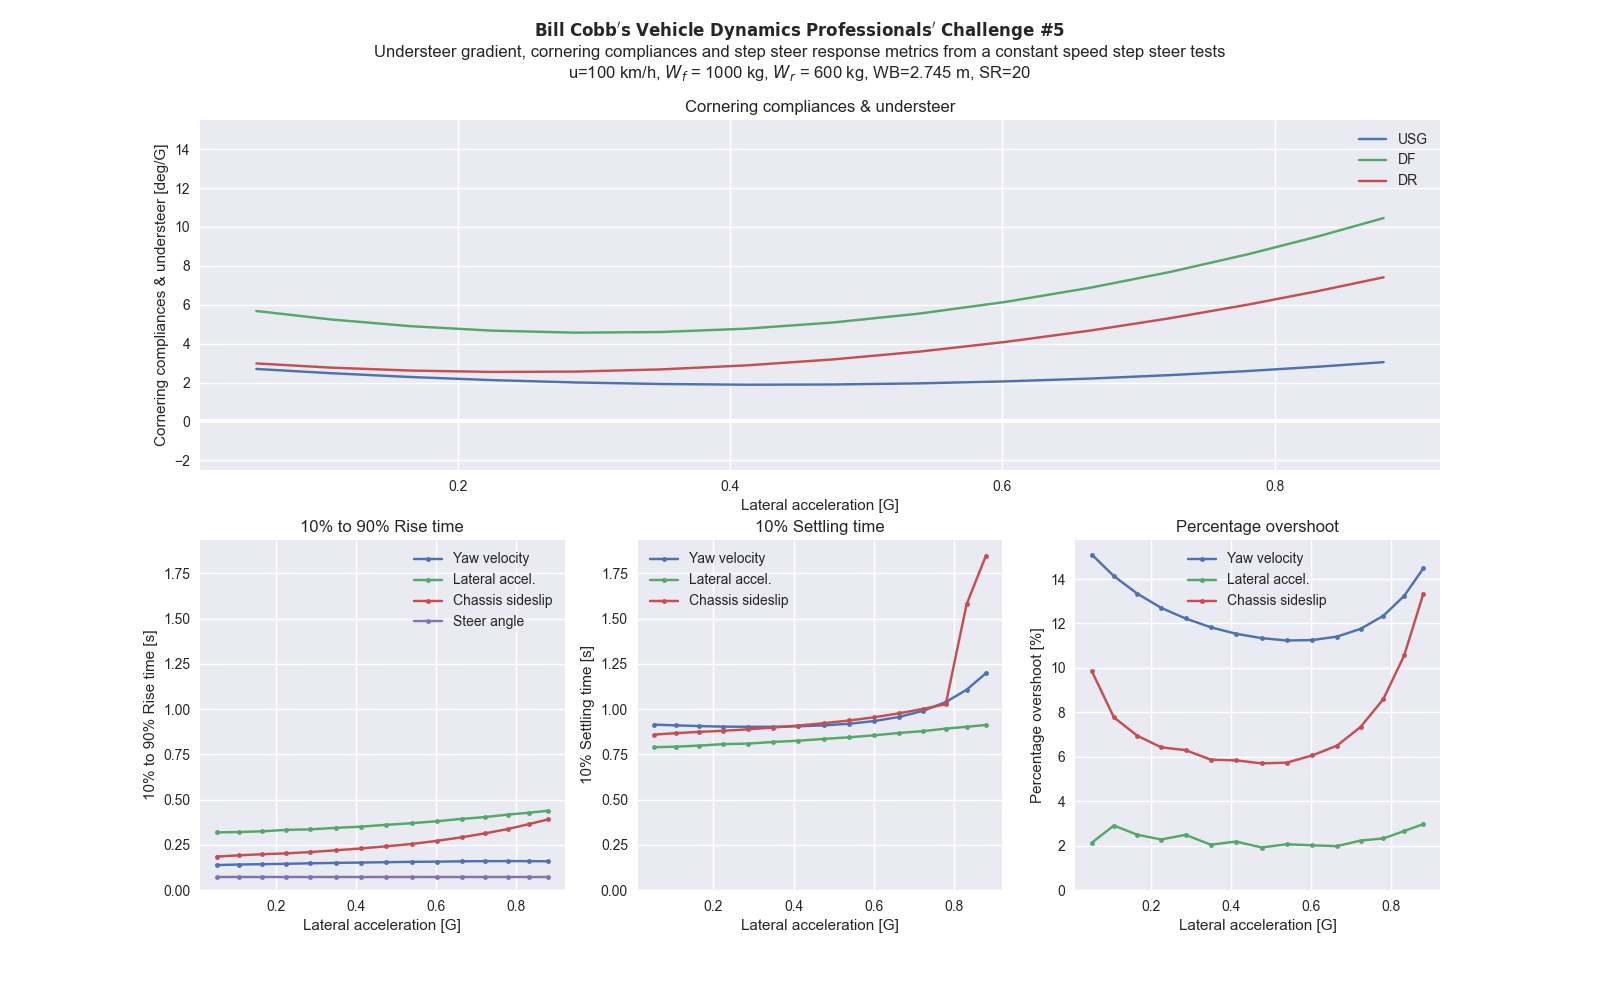

In [20]:
fig = plt.figure(figsize=(16*FIG_SCALE, 10*FIG_SCALE))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax2)
ax4 = fig.add_subplot(gs[1, 2], sharex=ax1)

# Understeer gradient and cornering compliancecs
ax1.plot(
    sdf[COLUMN_LATACC],
    sdf[COLUMN_USG, COLUMN_DF, COLUMN_DR] * RAD2DEG,
    label=["USG", "DF", "DR"],
)

ax1.axhline(0, color="white", linewidth=3, zorder=0)
ax1.set_ylim(bottom=-2.5, top=15.5)
ax1.set_xlabel("Lateral acceleration [G]")
ax1.set_ylabel("Cornering compliances & understeer [deg/G]")
ax1.set_title("Cornering compliances & understeer")
ax1.legend()

# Rise time
ax2.plot(slataccdf[COLUMN_SS], syawveldf[COLUMN_RT], marker='.', label="Yaw velocity")
ax2.plot(slataccdf[COLUMN_SS], slataccdf[COLUMN_RT], marker='.', label="Lateral accel.")
ax2.plot(slataccdf[COLUMN_SS], sbetadf[COLUMN_RT], marker='.', label="Chassis sideslip")
ax2.plot(slataccdf[COLUMN_SS], sdeltadf[COLUMN_RT], marker='.', label="Steer angle")
ax2.set_title("10% to 90% Rise time")
ax2.set_xlabel("Lateral acceleration [G]")
ax2.set_ylabel("10% to 90% Rise time [s]")
ax2.legend()

# Settling time
ax3.plot(slataccdf[COLUMN_SS], syawveldf[COLUMN_ST], marker='.', label="Yaw velocity")
ax3.plot(slataccdf[COLUMN_SS], slataccdf[COLUMN_ST], marker='.', label="Lateral accel.")
ax3.plot(slataccdf[COLUMN_SS], sbetadf[COLUMN_ST], marker='.', label="Chassis sideslip")
ax3.set_title("10% Settling time")
ax3.set_xlabel("Lateral acceleration [G]")
ax3.set_ylabel("10% Settling time [s]")
ax3.set_ylim(bottom=0)
ax3.legend()

# Overshoot
ax4.plot(slataccdf[COLUMN_SS], syawveldf[COLUMN_OS], marker='.', label="Yaw velocity")
ax4.plot(slataccdf[COLUMN_SS], slataccdf[COLUMN_OS], marker='.', label="Lateral accel.")
ax4.plot(slataccdf[COLUMN_SS], sbetadf[COLUMN_OS], marker='.', label="Chassis sideslip")
ax4.set_title("Percentage overshoot")
ax4.set_xlabel("Lateral acceleration [G]")
ax4.set_ylabel("Percentage overshoot [%]")
ax4.set_ylim(bottom=0)
ax4.legend()

fig.suptitle(
    r"$\mathbf{Bill\ Cobb's\ Vehicle\ Dynamics\ Professionals'\ Challenge\ \#5}$"
    + "\n"
    + "Understeer gradient, cornering compliances and step steer response metrics from a constant speed step steer tests"
    + "\n"
    + f"u={vehicle_speed*MPS2KPH:.0f} km/h, "
    + r"$W_f$ = 1000 kg, $W_r$ = 600 kg, WB=2.745 m, SR=20"
)

plt.tight_layout
plt.show()